In [1]:
cd ../..

/lfs/rambo/0/adobles/relbench-user-study


/lfs/local/0/adobles/miniconda3/envs/relbench/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Feature Ideas

- Basics
    - Body Length
    - Title Length
    - Num tags
    - Post Age in weeks
    - Post ordinal (ie what number of post this is for the user 1st, 2nd, 3rd, etc.)
    - Post type (Q or A)
    - Current Num Votes?
    - Deleted/undeleted weeks ago
    - Locked/unlocked weeks ago
    - Closed/reopened weeks ago
    - Bumped weeks ago
    - Tweeted weeks ago

- Owner Features:
    - Owner age in months
    - Owner average question popularity (first month)
    - Owner average answer popularity (first month)
    - Owner average question comments (first month)
    - Owner average answer comments (first month)

In [2]:
import duckdb
from torch_frame.utils import infer_df_stype

import utils

conn = duckdb.connect('stack_exchange/stackex.db')
%load_ext sql
%sql conn --alias duckdb
%config SqlMagic.displaycon=False
%config SqlMagic.autopandas=True

In [53]:
with open('stack_exchange/votes/feats.sql', 'r') as f:
    # run once with train_labels and once with val_labels
    template = f.read()

# create train, val and test features
# takes 1 - 5 mins
for s in ['train', 'val', 'test']:
    print(f'Creating {s} table')
    query = utils.render_jinja_sql(template, dict(set=s, subsample=0))
    conn.sql(query)
    print(f'{s} table created')

Creating train table
train table created
Creating val table
val table created
Creating test table
test table created


In [3]:
utils.validate_feature_tables('votes', conn)

Validating train
train labels size: 2,453,921 x 3
train feats size: 2,453,921 x 23

Validating val
val labels size: 156,216 x 3
val feats size: 156,216 x 23

Validating test
test labels size: 160,903 x 2
test feats size: 160,903 x 22

✅ All tables are valid!


In [4]:
%%sql train_df <<
from votes_train_feats

In [5]:
infer_df_stype(train_df)

{'PostId': <stype.numerical: 'numerical'>,
 'timestamp': <stype.timestamp: 'timestamp'>,
 'popularity': <stype.numerical: 'numerical'>,
 'post_type': <stype.categorical: 'categorical'>,
 'post_age_weeks': <stype.numerical: 'numerical'>,
 'title_length': <stype.categorical: 'categorical'>,
 'body_length': <stype.numerical: 'numerical'>,
 'num_tags': <stype.categorical: 'categorical'>,
 'user_age_months': <stype.numerical: 'numerical'>,
 'post_ordinal': <stype.numerical: 'numerical'>,
 'num_votes': <stype.numerical: 'numerical'>,
 'closed_weeks_ago': <stype.numerical: 'numerical'>,
 'reopened_weeks_ago': <stype.numerical: 'numerical'>,
 'deleted_weeks_ago': <stype.numerical: 'numerical'>,
 'undeleted_weeks_ago': <stype.numerical: 'numerical'>,
 'locked_weeks_ago': <stype.numerical: 'numerical'>,
 'unlocked_weeks_ago': <stype.numerical: 'numerical'>,
 'tweeted_weeks_ago': <stype.categorical: 'categorical'>,
 'bumped_weeks_ago': <stype.categorical: 'categorical'>,
 'avg_owner_question_upvo

In [8]:
utils.feature_summary_df(train_df.sample(20_000), 'popularity', classification=False)

/lfs/local/0/adobles/miniconda3/envs/relbench/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/lfs/local/0/adobles/miniconda3/envs/relbench/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,Label Corr.,Label MI,NaN %
num_votes,0.501,0.040,0.0%
avg_owner_answer_comments_first_month,-0.007,0.019,64.1%
post_type,nan,0.014,0.0%
deleted_weeks_ago,0.174,0.008,99.6%
avg_owner_question_upvotes_first_month,0.153,0.006,1.0%
PostId,-0.069,0.005,0.0%
tweeted_weeks_ago,-0.016,0.003,79.6%
reopened_weeks_ago,-0.067,0.002,99.0%
undeleted_weeks_ago,0.173,0.002,99.6%
title_length,-0.016,0.002,0.0%


## Feature Importances

In [9]:
import numpy as np
import shap
from torch_frame import TaskType, stype
from torch_frame.data import Dataset
from torch_frame.gbdt import LightGBM

from inferred_stypes import task_to_stypes
from train_gbdt import TASK_PARAMS

TASK = 'rel-stackex-votes'

task_params = TASK_PARAMS[TASK]

/lfs/local/0/adobles/miniconda3/envs/relbench/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
%%sql val_df <<
select * from votes_val_feats;

In [11]:
col_to_stype = task_to_stypes[TASK].copy()
val_tf = Dataset(
    val_df,
    col_to_stype=col_to_stype,
    target_col=task_params['target_col'],
).materialize().tensor_frame

In [12]:
gbdt = LightGBM(task_type=task_params['task_type'])
gbdt.load(f'models/{TASK}_lgbm.json')
pred = gbdt.predict(tf_test=val_tf).numpy()

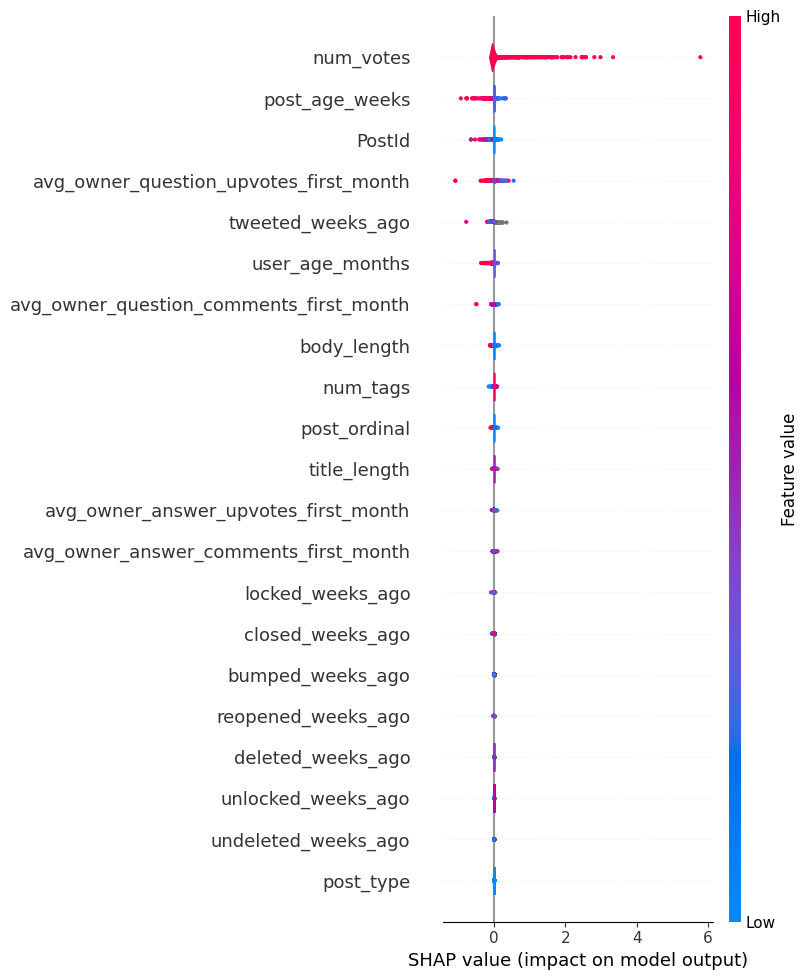

In [13]:
shap.initjs()
explainer = shap.TreeExplainer(gbdt.model)

sample = np.random.randint(0, len(val_tf), size=10_000)

val_arr, _, _ = gbdt._to_lightgbm_input(val_tf[sample])
shap_values = explainer.shap_values(val_arr, pred[sample])

# TODO verify
feat_names = val_tf.col_names_dict.get(stype.categorical, []) + val_tf.col_names_dict[stype.numerical]

shap.summary_plot(shap_values, val_arr, plot_type='violin', max_display=30, feature_names=feat_names)

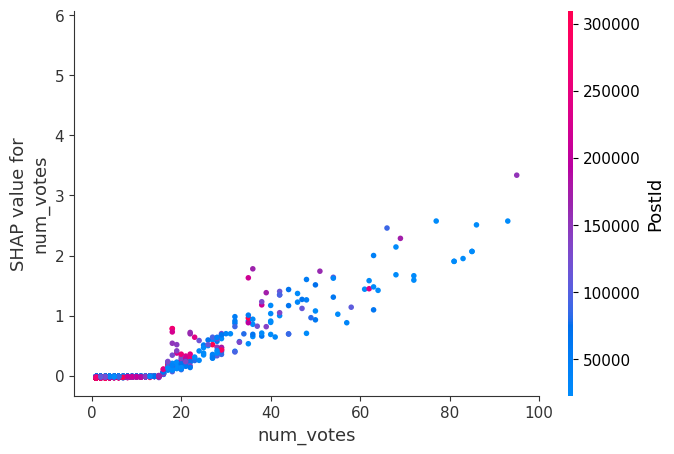

In [18]:
shap.dependence_plot('num_votes', shap_values, val_arr, feature_names=feat_names, xmax=100)

In [19]:
conn.close()